# Sorting

In [1]:
from qualtran import Bloq, CompositeBloq, BloqBuilder, Signature, Register
from qualtran import QBit, QInt, QUInt, QAny
from qualtran.drawing import show_bloq, show_call_graph, show_counts_sigma
from typing import *
import numpy as np
import sympy
import cirq

## `Comparator`
Compare and potentially swaps two n-bit numbers.

Implements $|a\rangle|b\rangle \mapsto |\min(a,b)\rangle|\max(a,b)\rangle|a>b\rangle$,

where $a$ and $b$ are n-qubit quantum registers. On output a and b are
swapped if a > b. Forms the base primitive for sorting.

#### Parameters
 - `bitsize`: value of $n$ (i.e. the inputs are $n$-bit numbers). 

#### Registers
 - `a`: A n-bit-sized input register (register a above).
 - `b`: A n-bit-sized input register (register b above).
 - `out`: A single bit output register which will store the result of the comparator. 

#### References
 - [Improved techniques for preparing eigenstates of fermionic Hamiltonians](https://www.nature.com/articles/s41534-018-0071-5). Fig. 1. in main text.


In [2]:
from qualtran.bloqs.arithmetic import Comparator

### Example Instances

In [3]:
comparator = Comparator(3)

In [4]:
n = sympy.Symbol('n')
comparator_symb = Comparator(n)

#### Graphical Signature

In [5]:
from qualtran.drawing import show_bloqs
show_bloqs([comparator, comparator_symb],
           ['`comparator`', '`comparator_symb`'])

### Call Graph

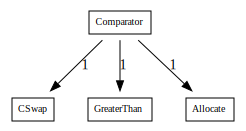

#### Counts totals:
 - `Allocate`: 1
 - `CSwap`: 1
 - `GreaterThan`: 1

In [6]:
from qualtran.resource_counting.generalizers import ignore_split_join
comparator_g, comparator_sigma = comparator.call_graph(max_depth=1, generalizer=ignore_split_join)
show_call_graph(comparator_g)
show_counts_sigma(comparator_sigma)

## `BitonicSort`
Sort k n-bit integers in-place using a Bitonic sorting network.

For a given input list $x_1, x_2, \ldots, x_k$, applies the transform

$$
    |x_1, x_2, \ldots, x_k\rangle \mapsto |y_1, y_2, \ldots, y_k\rangle|\mathsf{junk}\rangle
$$

where $y_1, y_2, \ldots, y_k = \mathrm{sorted}(x_1, x_2, \ldots, x_k)$, and the junk register
stores the result of comparisons done during the sorting. Note that the `junk` register will
be entangled with the input list register.

Currently only supports $k$ being a power of two (#1090).

The bitonic sorting network requires $\frac{k}{2} \frac{\log{k} (1+\log{k})}{2}$ total comparisons,
and has depth $\frac{\log{k} (1+\log{k})}{2}$, when $k$ is a power of 2. Each comparison generates
one ancilla qubit that stores the result of the comparison, so the total size of `junk` register
equals the number of comparisons.

#### Parameters
 - `k`: Number of integers to sort.
 - `bitsize`: number of bits $n$ of each input number. 

#### Registers
 - `xs`: List of k integers we want to sort.
 - `junk`: the generated ancilla qubits of each comparison in the sorting network. 

#### References
 - [Improved techniques for preparing eigenstates of fermionic Hamiltonians](https://www.nature.com/articles/s41534-018-0071-5). Supporting Information Sec. II.


In [7]:
from qualtran.bloqs.arithmetic import BitonicSort

### Example Instances

In [8]:
bitonic_sort = BitonicSort(8, 4)

In [9]:
n = sympy.Symbol('n')
bitonic_sort_symb = BitonicSort(4, n)

#### Graphical Signature

In [10]:
from qualtran.drawing import show_bloqs
show_bloqs([bitonic_sort, bitonic_sort_symb],
           ['`bitonic_sort`', '`bitonic_sort_symb`'])

### Call Graph

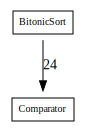

#### Counts totals:
 - `Comparator`: 24

In [11]:
from qualtran.resource_counting.generalizers import ignore_split_join
bitonic_sort_g, bitonic_sort_sigma = bitonic_sort.call_graph(max_depth=1, generalizer=ignore_split_join)
show_call_graph(bitonic_sort_g)
show_counts_sigma(bitonic_sort_sigma)

## `ParallelComparators`
Given k n-bit numbers, for each pair that is `offset` apart, compare and swap if needed to order them.

For each block of `2 * offset` numbers, apply a `Comparator` between each pair that is `offset` apart.
For an offset of $\delta$, this requires

$$
    \delta \left\lfloor \frac{k}{2\delta} \right\rfloor
    + \max((k\mod 2\delta) - \delta, 0)
$$

totals comparisons. The above expression is at most $k / 2$. Each comparison generates one ancilla qubit
which stores the result of comparsion, and these qubits are aggregated into the `junk` register.

This is used by `BitonicMerge` to apply parallel merges with offsets 1, 2, 4 and so on.

#### Parameters
 - `k`: size of the input list.
 - `offset`: compare numbers whose indices are offset apart.
 - `bitsize`: value of $n$ (i.e. the inputs are $n$-bit numbers). 

#### Registers
 - `xs`: input list of numbers.
 - `junk`: ancilla generated by comparators.


In [12]:
from qualtran.bloqs.arithmetic.sorting import ParallelComparators

### Example Instances

In [13]:
parallel_compare = ParallelComparators(7, 2, bitsize=3)

#### Graphical Signature

In [14]:
from qualtran.drawing import show_bloqs
show_bloqs([parallel_compare],
           ['`parallel_compare`'])

### Call Graph

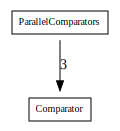

#### Counts totals:
 - `Comparator`: 3

In [15]:
from qualtran.resource_counting.generalizers import ignore_split_join
parallel_compare_g, parallel_compare_sigma = parallel_compare.call_graph(max_depth=1, generalizer=ignore_split_join)
show_call_graph(parallel_compare_g)
show_counts_sigma(parallel_compare_sigma)

## `BitonicMerge`
Merge two sorted sequences of n-bit integers.

Given two sorted lists of length `half_length`, merges them inplace into a single
sorted list.

Currently only supports `half_length` equal to a power of two (#1090).

If each half has length $k$, then the merge network uses $k (1+\log{k})$ comparisons
when $k$ is a power of 2. Each comparison generates one ancilla qubit which stores
the result of comparsion, and these qubits are aggregated into the `junk` register.

#### Parameters
 - `half_length`: Number of integers in each half
 - `bitsize`: value of $n$ (i.e. the inputs are $n$-bit numbers). 

#### Registers
 - `xs`: first input list of size `half_length`
 - `ys`: second input list of size `half_length`
 - `result`: merged output list of size `2 * half_length`
 - `junk`: ancilla generated by comparators.


In [16]:
from qualtran.bloqs.arithmetic.sorting import BitonicMerge

### Example Instances

In [17]:
bitonic_merge = BitonicMerge(4, 7)

#### Graphical Signature

In [18]:
from qualtran.drawing import show_bloqs
show_bloqs([bitonic_merge],
           ['`bitonic_merge`'])

### Call Graph

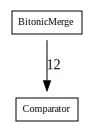

#### Counts totals:
 - `Comparator`: 12

In [19]:
from qualtran.resource_counting.generalizers import ignore_split_join
bitonic_merge_g, bitonic_merge_sigma = bitonic_merge.call_graph(max_depth=1, generalizer=ignore_split_join)
show_call_graph(bitonic_merge_g)
show_counts_sigma(bitonic_merge_sigma)